In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import os
import ast
import matplotlib.pyplot as plt

In [2]:
def calculate_probability(num_list, threshold = 0.6):
    nums = len([i for i in num_list if i >= threshold])
    return nums / len(num_list)

def group_files(directory: str = './', mode:str = 'sigma_interest_rates'):
    grouped_files = {}
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            parts = filename.split('_')
            if mode == 'sigma_interest_rates':
                key = tuple(parts[:4] + parts[5:-1])
                if key not in grouped_files:
                    grouped_files[key] = {'filenames': [], 'sigma_interest_rates': []}
                grouped_files[key]['filenames'].append(filename)
                grouped_files[key]['sigma_interest_rates'].append(parts[4])
            if mode == 'sigma_exposure_node':
                key = tuple(parts[:3] + parts[4:-1])
                if key not in grouped_files:
                    grouped_files[key] = {'filenames': [], 'sigma_exposure_node': []}
                grouped_files[key]['filenames'].append(filename)
                grouped_files[key]['sigma_exposure_node'].append(parts[3])
    return grouped_files

In [3]:
def plot_avalanche_prob_vs_volatility(directory:str = './', threshold = 10, mode:str = 'sigma_interest_rates'):
    
    groups = group_files(directory, mode)

    for key, value in groups.items():
        print("Key:", key)
        bankrupt_nodes_list = []
        filenames = value['filenames']
        for filename in filenames:
            full_path = os.path.join(directory, filename)
            df = pd.read_csv(full_path)
            bankrupt_nodes = []
            for i in range(len(df)):
                if pd.isna(df['Abs Difference of Bankrupt Agents Over Time'].iloc[i]) or pd.isna(df['Number of Bankrupt Agents Over Time'].iloc[i]):
                    continue
                else: 
                    bankrupt_node = calculate_probability(ast.literal_eval(df['Abs Difference of Bankrupt Agents Over Time'].iloc[i]), threshold = threshold)
                    bankrupt_nodes.append(bankrupt_node)
            bankrupt_nodes_list.append(bankrupt_nodes)

        if mode == 'sigma_interest_rates':
            sigmas = value['sigma_interest_rates']
        if mode == 'sigma_exposure_node':
            sigmas = value['sigma_exposure_node']
            
        combined = sorted(zip(sigmas, bankrupt_nodes_list))
        sigmas_sorted, bankrupt_nodes_list_sorted = zip(*combined)
        plt.figure(figsize=(10, 6))
        plt.boxplot(bankrupt_nodes_list_sorted, labels=sigmas_sorted)
        plt.xlabel(mode.replace('_', ' ').title())
        plt.ylabel('Default Prob')
        plt.title('Avalanche Prob vs. Volatility')
        plt.show()

Key: ('100', '2000', '1', '1', '5', '1', '3', '400', 'hard cutoff', 'divide exposure singly', 'intrest', 'rate')


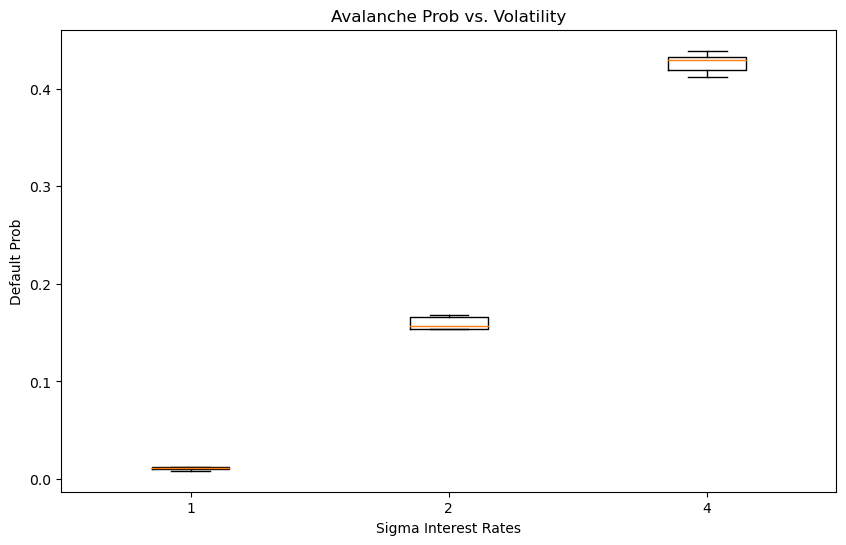

In [4]:
plot_avalanche_prob_vs_volatility(directory = 'interest', threshold = 20, mode='sigma_interest_rates')

Key: ('100', '2000', '1', '1', '5', '1', '3', '400', 'hard cutoff', 'random link logic', 'exposure')


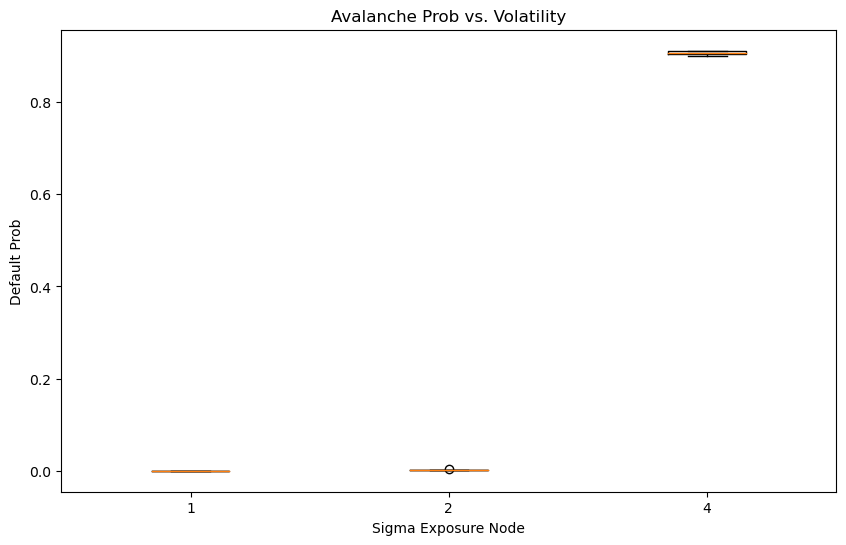

Key: ('100', '2000', '1', '1', '5', '1', '3', '400', 'hard cutoff', 'divide exposure singly', 'intrest', 'rate')


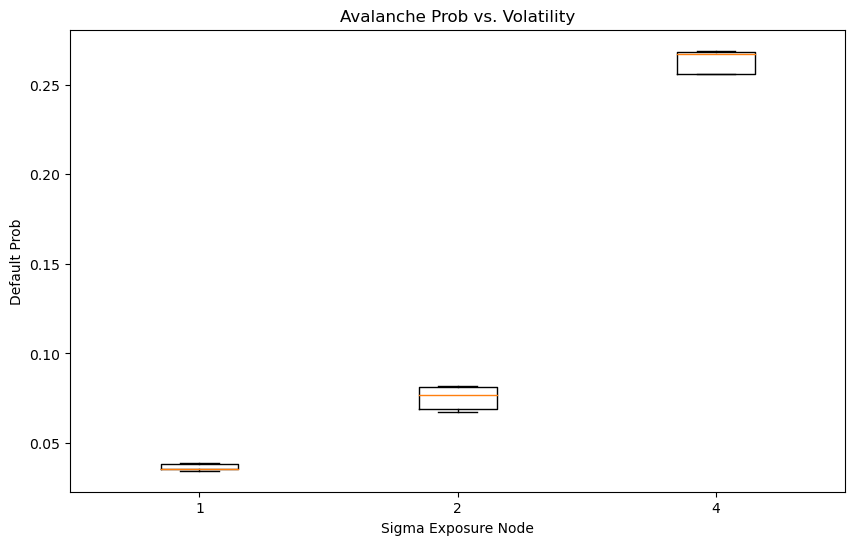

In [5]:
plot_avalanche_prob_vs_volatility(directory = 'exposure', threshold = 10, mode='sigma_exposure_node')

In [9]:
def stress_vs_avalanche_prob_vs_volatility(directory:str = './', threshold = 10, mode:str = 'sigma_interest_rates'):
    
    groups = group_files(directory, mode)

    for key, value in groups.items():
        print("Key:", key)
        bankrupt_nodes_avg_list = []
        total_edge_exposures = []
        filenames = value['filenames']
        for filename in filenames:
            full_path = os.path.join(directory, filename)
            df = pd.read_csv(full_path)
            bankrupt_nodes = []
            for i in range(len(df)):
                if pd.isna(df['Abs Difference of Bankrupt Agents Over Time'].iloc[i]) or pd.isna(df['Number of Bankrupt Agents Over Time'].iloc[i]):
                    continue
                else: 
                    bankrupt_node = calculate_probability(ast.literal_eval(df['Abs Difference of Bankrupt Agents Over Time'].iloc[i]), threshold = threshold)
                    bankrupt_nodes.append(bankrupt_node)
            bankrupt_nodes_avg = np.mean(bankrupt_nodes)
            bankrupt_nodes_avg_list.append(bankrupt_nodes_avg)

            exposures = [ast.literal_eval(x) for x in df['Total Absolute Exposure in Edge Weights'] if not pd.isna(x)]
            exposures_avg = [np.mean(x) for x in exposures]
            total_edge_exposure_avg = np.mean(exposures_avg)
            total_edge_exposures.append(total_edge_exposure_avg)

            
        if mode == 'sigma_interest_rates':
            sigmas = value['sigma_interest_rates']
        if mode == 'sigma_exposure_node':
            sigmas = value['sigma_exposure_node']

        sigmas = [float(sigma) for sigma in sigmas]
        combined = sorted(zip(sigmas, bankrupt_nodes_avg_list, total_edge_exposures))
        sigmas_sorted, bankrupt_nodes_list_sorted, total_edge_exposures_sorted = zip(*combined)


    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_trisurf(sigmas_sorted, total_edge_exposures_sorted, bankrupt_nodes_list_sorted)

    ax.set_xlabel(mode.replace('_', ' ').title())
    ax.set_ylabel('Total Absolute Exposure in Edge Weights')
    ax.set_zlabel('Default Prob')
    ax.set_title('Stress vs. Avalanche Prob vs. Volatility', fontdict={'fontsize': 14})
    ax.view_init(elev=30, azim=60)

    plt.show()

Key: ('100', '2000', '1', '1', '5', '1', '3', '400', 'hard cutoff', 'divide exposure singly', 'intrest', 'rate')
[4.0, 2.0, 1.0]


<IPython.core.display.Javascript object>


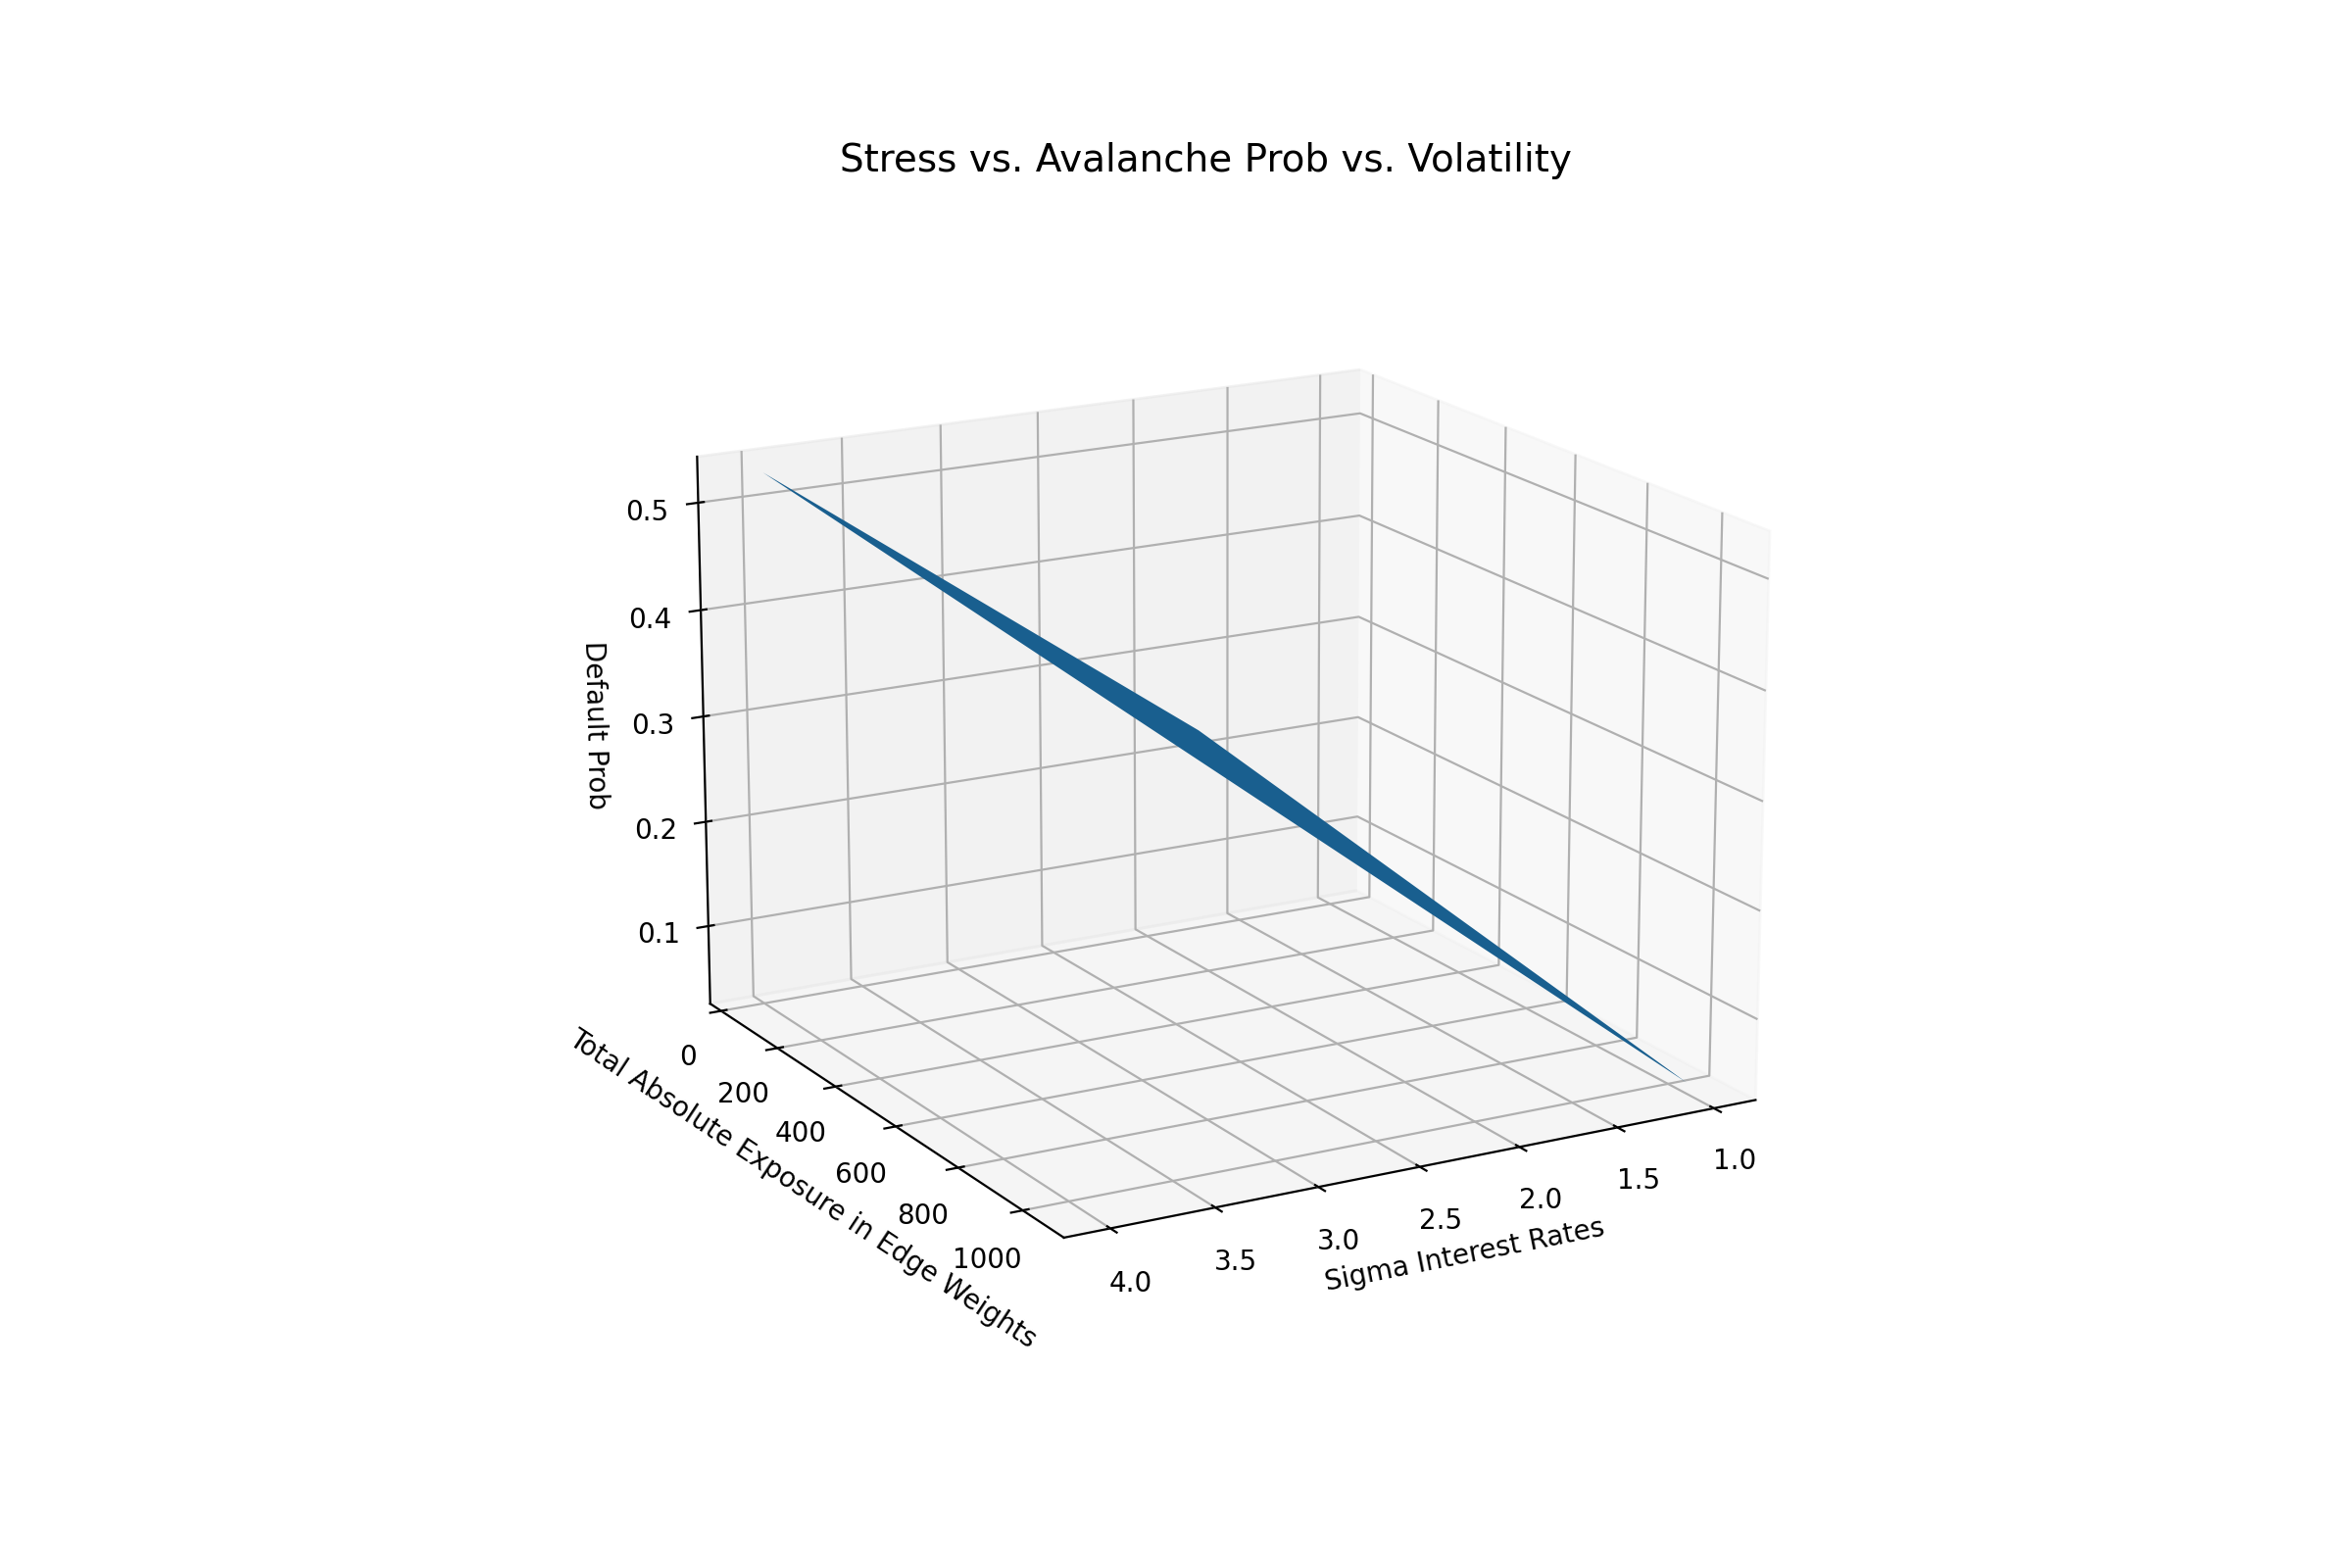

In [10]:
stress_vs_avalanche_prob_vs_volatility(directory='interest')